In [40]:
import numpy as np 
import os 
import glob
from tqdm.auto import tqdm
import pandas as pd 
import re
import tensorflow as tf
from matplotlib import pyplot as plt

# Load all files

In [28]:
train = pd.read_csv("../input/cardiovascular-disease-identification-2nd/train.csv")
test = pd.read_csv("../input/cardiovascular-disease-identification-2nd/test.csv")
submission = pd.read_csv("../input/cardiovascular-disease-identification-2nd/sample_submission.csv")

In [29]:
train["text"] = ["" for _ in  range(train.shape[0])]
test["text"] = ["" for _ in  range(test.shape[0])]

In [30]:
classes = glob.glob("../input/cardiovascular-disease-identification-2nd/data/data/train/*")

In [31]:
NUM_CLASSES = len(classes)
def load_train_text(train):
    for path_id in tqdm(range(NUM_CLASSES)):
        
        path = classes[path_id]
        docPaths = glob.glob(os.path.join(path,'*'))
        for docPath in docPaths:
            with open(docPath, 'r') as f:
                text = f.read()
            filename = int(docPath[71:])
            indice = train[train.filename == filename].index
            train.loc[indice,"text"] = text
           

def load_test_text(test):
    docPaths = glob.glob("../input/cardiovascular-disease-identification-2nd/data/data/test/*")
    
    for docPath in tqdm(docPaths):
        with open(docPath, 'r') as f:
            text = f.read()
        filename = int(docPath[67:])
        indice = test[test.filename == filename].index
        test.loc[indice,"text"] = text
     


In [32]:
load_train_text(train)
load_test_text(test)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/7643 [00:00<?, ?it/s]

# Preprocess & cleaning

In [33]:
def process_text(text) : 
    
    text = text.lower()
    text = re.sub( r'[0-9]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace("\n" ,"")
    text = text.strip()
    
    return text 

In [34]:
train.text = train.text.apply(process_text)
test.text = test.text.apply(process_text)

In [35]:
VOCAB_SIZE = 200000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train["text"])

In [36]:
X_train= train.text
y_train = train.iloc[:,1:24]

In [37]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(23,activation = "softmax")
])

In [38]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs=20)

Epoch 1/20
197/197 [==============================] - 36s 89ms/step - loss: 0.0637 - accuracy: 0.0848
Epoch 2/20
197/197 [==============================] - 17s 87ms/step - loss: 0.0582 - accuracy: 0.2754
Epoch 3/20
197/197 [==============================] - 17s 87ms/step - loss: 0.0531 - accuracy: 0.3384
Epoch 4/20
197/197 [==============================] - 17s 84ms/step - loss: 0.0498 - accuracy: 0.3729
Epoch 5/20
197/197 [==============================] - 17s 87ms/step - loss: 0.0470 - accuracy: 0.4098
Epoch 6/20
197/197 [==============================] - 17s 84ms/step - loss: 0.0450 - accuracy: 0.4316
Epoch 7/20
197/197 [==============================] - 17s 85ms/step - loss: 0.0429 - accuracy: 0.4704
Epoch 8/20
197/197 [==============================] - 17s 84ms/step - loss: 0.0401 - accuracy: 0.5084
Epoch 9/20
197/197 [==============================] - 17s 86ms/step - loss: 0.0377 - accuracy: 0.5452
Epoch 10/20
197/197 [==============================] - 17s 84ms/step - loss: 0.035

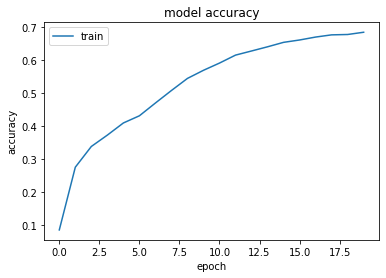

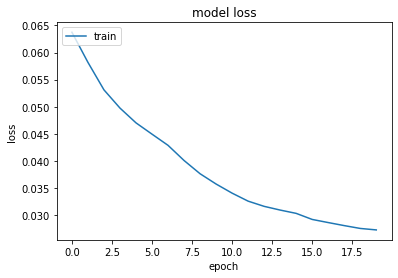

In [42]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
preds = model.predict(test.text)

In [45]:
 preds = np.round(preds,0).astype(int)

In [46]:
filename = list(test['filename'].values)

In [52]:
submission = pd.DataFrame(preds, columns=['target_' + str(i) if i > 9 else 'target_0' + str(i) for i in range(23)])

In [54]:
submission['filename'] = filename

In [55]:
submission.to_csv('submission.csv', index=False)